In [3]:
#Cell 1: Setup and Improved BERT Trainer
# Setup for hyperparameter tuning
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

# Improved BERT Trainer with early stopping
class ImprovedBERTTrainer:
    def __init__(self, patience=2):
        self.early_stopping_patience = patience
        self.best_val_accuracy = 0
        self.patience_counter = 0
        self.best_model_state = None
        
    def train_with_early_stopping(self, model, train_loader, val_loader, epochs=4, learning_rate=2e-5):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        
        train_losses = []
        val_accuracies = []
        
        for epoch in range(epochs):
            # Training phase
            model.train()
            total_train_loss = 0
            
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} Training')
            for batch in train_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_train_loss += loss.item()
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                train_pbar.set_postfix({'loss': loss.item()})
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            val_accuracy = self.evaluate_model(model, val_loader, device)
            val_accuracies.append(val_accuracy)
            
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
            
            # Early stopping check
            if val_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = val_accuracy
                self.best_model_state = model.state_dict().copy()
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                
            if self.patience_counter >= self.early_stopping_patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                model.load_state_dict(self.best_model_state)
                break
        
        return {
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_accuracy': self.best_val_accuracy
        }
    
    def evaluate_model(self, model, data_loader, device):
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        return correct / total

print("Improved BERT Trainer class defined successfully")

Libraries imported successfully
Improved BERT Trainer class defined successfully


In [5]:
#Cell 2: Data Loading and Preparation
# Load processed data
print("Loading processed datasets...")
train_df = pd.read_csv('../data/train_split.csv')
val_df = pd.read_csv('../data/val_split.csv')

X_train = train_df['cleaned_text']
y_train = train_df['target']
X_val = val_df['cleaned_text']
y_val = val_df['target']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Dataset class
class DisasterTweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Data preparation completed")

Loading processed datasets...
Training samples: 6090
Validation samples: 1523
Data preparation completed


LEARNING RATE EXPERIMENTS


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing learning rate: 1e-05


Epoch 1 Training: 100%|██████████| 381/381 [00:31<00:00, 12.04it/s, loss=0.239]


Epoch 1: Train Loss: 0.4711, Val Accuracy: 0.8444


Epoch 2 Training: 100%|██████████| 381/381 [00:30<00:00, 12.34it/s, loss=0.333] 


Epoch 2: Train Loss: 0.3669, Val Accuracy: 0.8536


Epoch 3 Training: 100%|██████████| 381/381 [00:31<00:00, 12.28it/s, loss=0.179] 


Epoch 3: Train Loss: 0.3203, Val Accuracy: 0.8470


Epoch 4 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.294] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4: Train Loss: 0.2871, Val Accuracy: 0.8483
Early stopping triggered at epoch 4
Best validation accuracy with lr=1e-05: 0.8536

Testing learning rate: 2e-05


Epoch 1 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.36] 


Epoch 1: Train Loss: 0.4424, Val Accuracy: 0.8359


Epoch 2 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.484] 


Epoch 2: Train Loss: 0.3345, Val Accuracy: 0.8477


Epoch 3 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.061] 


Epoch 3: Train Loss: 0.2608, Val Accuracy: 0.8437


Epoch 4 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.0964]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4: Train Loss: 0.2054, Val Accuracy: 0.8326
Early stopping triggered at epoch 4
Best validation accuracy with lr=2e-05: 0.8477

Testing learning rate: 5e-05


Epoch 1 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.494]


Epoch 1: Train Loss: 0.4572, Val Accuracy: 0.8247


Epoch 2 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.182] 


Epoch 2: Train Loss: 0.3299, Val Accuracy: 0.8372


Epoch 3 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.178] 


Epoch 3: Train Loss: 0.2129, Val Accuracy: 0.8293


Epoch 4 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.0125] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4: Train Loss: 0.1327, Val Accuracy: 0.8260
Early stopping triggered at epoch 4
Best validation accuracy with lr=5e-05: 0.8372

Testing learning rate: 0.0001


Epoch 1 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.161]


Epoch 1: Train Loss: 0.4766, Val Accuracy: 0.8326


Epoch 2 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.263] 


Epoch 2: Train Loss: 0.3470, Val Accuracy: 0.8109


Epoch 3 Training: 100%|██████████| 381/381 [00:31<00:00, 12.26it/s, loss=0.0243]


Epoch 3: Train Loss: 0.2396, Val Accuracy: 0.8030
Early stopping triggered at epoch 3
Best validation accuracy with lr=0.0001: 0.8326


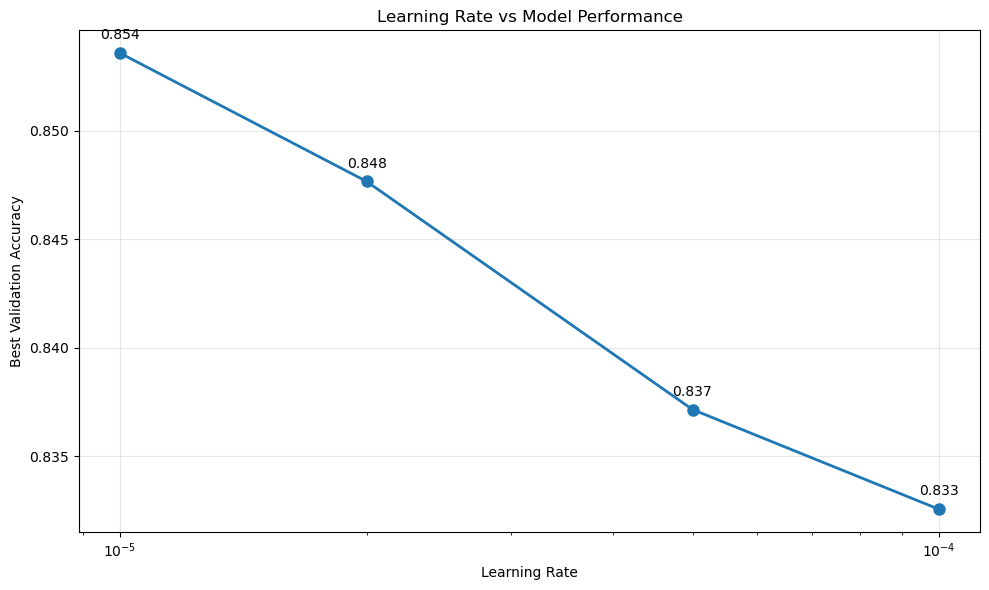


Best learning rate: 1e-05 with accuracy: 0.8536


In [6]:
#Cell 3: Learning Rate Experiments
# Learning rate hyperparameter tuning
print("LEARNING RATE EXPERIMENTS")
print("=" * 40)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = DisasterTweetDataset(X_train, y_train, tokenizer)
val_dataset = DisasterTweetDataset(X_val, y_val, tokenizer)

learning_rates = [1e-5, 2e-5, 5e-5, 1e-4]
lr_results = {}

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")
    
    # Reinitialize model for each experiment
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    trainer = ImprovedBERTTrainer(patience=2)
    results = trainer.train_with_early_stopping(model, train_loader, val_loader, learning_rate=lr, epochs=4)
    
    lr_results[lr] = {
        'best_val_accuracy': results['best_val_accuracy'],
        'train_losses': results['train_losses'],
        'val_accuracies': results['val_accuracies'],
        'epochs_trained': len(results['train_losses'])
    }
    
    print(f"Best validation accuracy with lr={lr}: {results['best_val_accuracy']:.4f}")

# Plot learning rate results
plt.figure(figsize=(10, 6))
lrs = list(lr_results.keys())
accuracies = [lr_results[lr]['best_val_accuracy'] for lr in lrs]

plt.plot(lrs, accuracies, marker='o', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Best Validation Accuracy')
plt.title('Learning Rate vs Model Performance')
plt.grid(True, alpha=0.3)

for i, (lr, acc) in enumerate(zip(lrs, accuracies)):
    plt.annotate(f'{acc:.3f}', (lr, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Find best learning rate
best_lr = max(lr_results, key=lambda x: lr_results[x]['best_val_accuracy'])
print(f"\nBest learning rate: {best_lr} with accuracy: {lr_results[best_lr]['best_val_accuracy']:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BATCH SIZE EXPERIMENTS

Testing batch size: 8


Epoch 1 Training: 100%|██████████| 762/762 [00:35<00:00, 21.65it/s, loss=0.0481]


Epoch 1: Train Loss: 0.4593, Val Accuracy: 0.8418


Epoch 2 Training: 100%|██████████| 762/762 [00:35<00:00, 21.68it/s, loss=0.119] 


Epoch 2: Train Loss: 0.3603, Val Accuracy: 0.8496


Epoch 3 Training: 100%|██████████| 762/762 [00:35<00:00, 21.64it/s, loss=0.0195] 


Epoch 3: Train Loss: 0.2771, Val Accuracy: 0.8359


Epoch 4 Training: 100%|██████████| 762/762 [00:35<00:00, 21.62it/s, loss=1.47]   
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4: Train Loss: 0.2210, Val Accuracy: 0.8267
Early stopping triggered at epoch 4
Best validation accuracy with batch_size=8: 0.8496

Testing batch size: 16


Epoch 1 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.247]


Epoch 1: Train Loss: 0.4529, Val Accuracy: 0.8437


Epoch 2 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.547] 


Epoch 2: Train Loss: 0.3418, Val Accuracy: 0.8332


Epoch 3 Training: 100%|██████████| 381/381 [00:31<00:00, 12.25it/s, loss=0.0655]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3: Train Loss: 0.2635, Val Accuracy: 0.8253
Early stopping triggered at epoch 3
Best validation accuracy with batch_size=16: 0.8437

Testing batch size: 32


Epoch 1 Training: 100%|██████████| 191/191 [00:28<00:00,  6.77it/s, loss=0.349]


Epoch 1: Train Loss: 0.4582, Val Accuracy: 0.8378


Epoch 2 Training: 100%|██████████| 191/191 [00:27<00:00,  6.84it/s, loss=0.191]


Epoch 2: Train Loss: 0.3481, Val Accuracy: 0.8372


Epoch 3 Training: 100%|██████████| 191/191 [00:27<00:00,  6.84it/s, loss=0.183] 


Epoch 3: Train Loss: 0.2885, Val Accuracy: 0.8378
Early stopping triggered at epoch 3
Best validation accuracy with batch_size=32: 0.8378


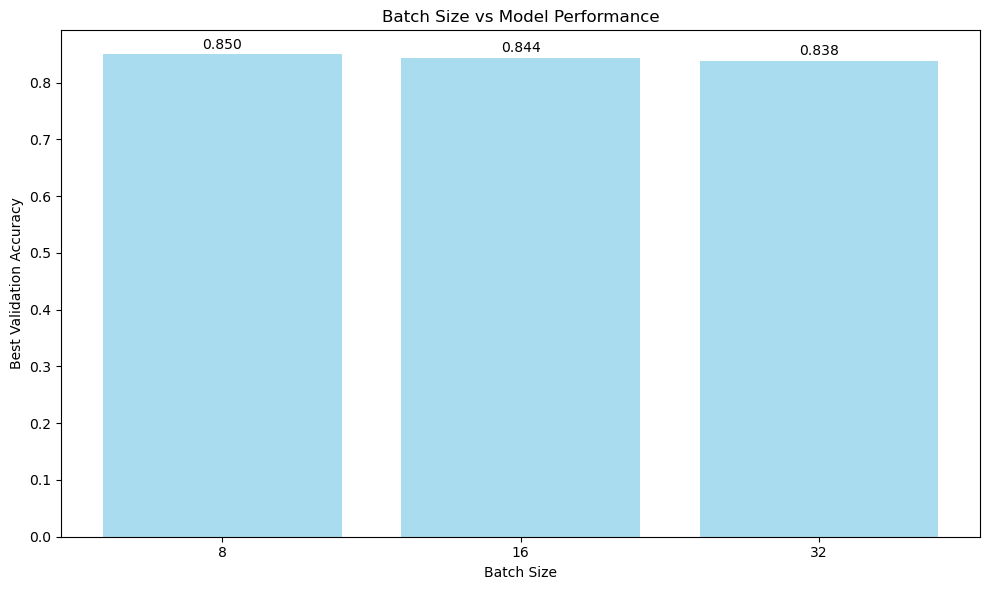


Best batch size: 8 with accuracy: 0.8496


In [7]:
#Cell 4: Batch Size Experiments
# Batch size hyperparameter tuning
print("BATCH SIZE EXPERIMENTS")
print("=" * 40)

batch_sizes = [8, 16, 32]
batch_results = {}
best_lr = 2e-5  # From previous experiments

for batch_size in batch_sizes:
    print(f"\nTesting batch size: {batch_size}")
    
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    trainer = ImprovedBERTTrainer(patience=2)
    results = trainer.train_with_early_stopping(model, train_loader, val_loader, learning_rate=best_lr, epochs=4)
    
    batch_results[batch_size] = {
        'best_val_accuracy': results['best_val_accuracy'],
        'train_losses': results['train_losses'],
        'val_accuracies': results['val_accuracies'],
        'training_time': len(results['train_losses'])  # Simplified time metric
    }
    
    print(f"Best validation accuracy with batch_size={batch_size}: {results['best_val_accuracy']:.4f}")

# Plot batch size results
plt.figure(figsize=(10, 6))
batch_sizes_list = list(batch_results.keys())
accuracies = [batch_results[bs]['best_val_accuracy'] for bs in batch_sizes_list]

plt.bar(range(len(batch_sizes_list)), accuracies, color='skyblue', alpha=0.7)
plt.xlabel('Batch Size')
plt.ylabel('Best Validation Accuracy')
plt.title('Batch Size vs Model Performance')
plt.xticks(range(len(batch_sizes_list)), batch_sizes_list)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

best_batch_size = max(batch_results, key=lambda x: batch_results[x]['best_val_accuracy'])
print(f"\nBest batch size: {best_batch_size} with accuracy: {batch_results[best_batch_size]['best_val_accuracy']:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SEQUENCE LENGTH EXPERIMENTS

Testing sequence length: 64


Epoch 1 Training: 100%|██████████| 381/381 [00:17<00:00, 21.17it/s, loss=0.481]


Epoch 1: Train Loss: 0.4503, Val Accuracy: 0.8542


Epoch 2 Training: 100%|██████████| 381/381 [00:17<00:00, 21.24it/s, loss=0.18]  


Epoch 2: Train Loss: 0.3452, Val Accuracy: 0.8345


Epoch 3 Training: 100%|██████████| 381/381 [00:17<00:00, 21.24it/s, loss=0.308] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3: Train Loss: 0.2692, Val Accuracy: 0.8385
Early stopping triggered at epoch 3
Best validation accuracy with seq_len=64: 0.8542

Testing sequence length: 128


Epoch 1 Training: 100%|██████████| 381/381 [00:31<00:00, 12.28it/s, loss=0.37] 


Epoch 1: Train Loss: 0.4541, Val Accuracy: 0.8359


Epoch 2 Training: 100%|██████████| 381/381 [00:31<00:00, 12.27it/s, loss=0.0757]


Epoch 2: Train Loss: 0.3387, Val Accuracy: 0.8345


Epoch 3 Training: 100%|██████████| 381/381 [00:31<00:00, 12.26it/s, loss=0.0616]


Epoch 3: Train Loss: 0.2695, Val Accuracy: 0.8378


Epoch 4 Training: 100%|██████████| 381/381 [00:31<00:00, 12.26it/s, loss=0.0271]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4: Train Loss: 0.2055, Val Accuracy: 0.8398
Best validation accuracy with seq_len=128: 0.8398

Testing sequence length: 256


Epoch 1 Training: 100%|██████████| 381/381 [00:56<00:00,  6.79it/s, loss=0.141]


Epoch 1: Train Loss: 0.4483, Val Accuracy: 0.8378


Epoch 2 Training: 100%|██████████| 381/381 [00:56<00:00,  6.79it/s, loss=0.198] 


Epoch 2: Train Loss: 0.3373, Val Accuracy: 0.8450


Epoch 3 Training: 100%|██████████| 381/381 [00:56<00:00,  6.79it/s, loss=0.101] 


Epoch 3: Train Loss: 0.2635, Val Accuracy: 0.8306


Epoch 4 Training: 100%|██████████| 381/381 [00:56<00:00,  6.79it/s, loss=0.0356]


Epoch 4: Train Loss: 0.2002, Val Accuracy: 0.8352
Early stopping triggered at epoch 4
Best validation accuracy with seq_len=256: 0.8450


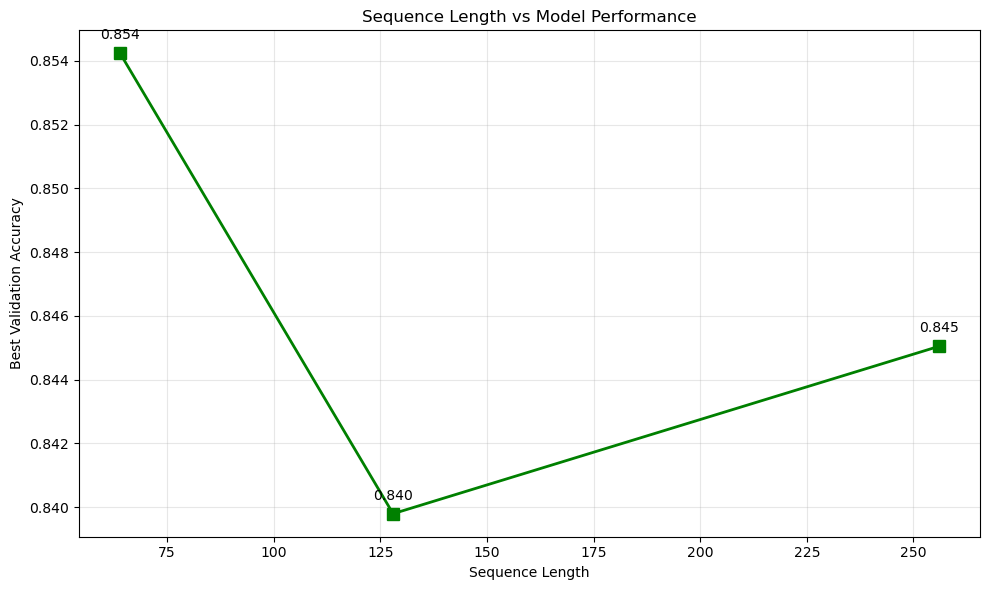


Best sequence length: 64 with accuracy: 0.8542


In [8]:
#Cell 5: Sequence Length Experiments
# Sequence length hyperparameter tuning
print("SEQUENCE LENGTH EXPERIMENTS")
print("=" * 45)

sequence_lengths = [64, 128, 256]
seq_results = {}

for seq_len in sequence_lengths:
    print(f"\nTesting sequence length: {seq_len}")
    
    # Create datasets with different sequence lengths
    train_dataset_seq = DisasterTweetDataset(X_train, y_train, tokenizer, max_length=seq_len)
    val_dataset_seq = DisasterTweetDataset(X_val, y_val, tokenizer, max_length=seq_len)
    
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    train_loader = DataLoader(train_dataset_seq, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset_seq, batch_size=16, shuffle=False)
    
    trainer = ImprovedBERTTrainer(patience=2)
    results = trainer.train_with_early_stopping(model, train_loader, val_loader, learning_rate=best_lr, epochs=4)
    
    seq_results[seq_len] = {
        'best_val_accuracy': results['best_val_accuracy'],
        'train_losses': results['train_losses'],
        'val_accuracies': results['val_accuracies']
    }
    
    print(f"Best validation accuracy with seq_len={seq_len}: {results['best_val_accuracy']:.4f}")

# Plot sequence length results
plt.figure(figsize=(10, 6))
seq_lengths_list = list(seq_results.keys())
accuracies = [seq_results[sl]['best_val_accuracy'] for sl in seq_lengths_list]

plt.plot(seq_lengths_list, accuracies, marker='s', linewidth=2, markersize=8, color='green')
plt.xlabel('Sequence Length')
plt.ylabel('Best Validation Accuracy')
plt.title('Sequence Length vs Model Performance')
plt.grid(True, alpha=0.3)

for i, (seq_len, acc) in enumerate(zip(seq_lengths_list, accuracies)):
    plt.annotate(f'{acc:.3f}', (seq_len, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

best_seq_len = max(seq_results, key=lambda x: seq_results[x]['best_val_accuracy'])
print(f"\nBest sequence length: {best_seq_len} with accuracy: {seq_results[best_seq_len]['best_val_accuracy']:.4f}")

MODEL ARCHITECTURE COMPARISON


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing distilbert architecture...


Epoch 1 Training: 100%|██████████| 762/762 [00:22<00:00, 34.04it/s, loss=0.262] 


Epoch 1: Train Loss: 0.4563, Val Accuracy: 0.8319


Epoch 2 Training: 100%|██████████| 762/762 [00:22<00:00, 34.09it/s, loss=0.0307]


Epoch 2: Train Loss: 0.3594, Val Accuracy: 0.8523


Epoch 3 Training: 100%|██████████| 762/762 [00:22<00:00, 34.10it/s, loss=0.104]  


Epoch 3: Train Loss: 0.2883, Val Accuracy: 0.8332


Epoch 4 Training: 100%|██████████| 762/762 [00:22<00:00, 34.10it/s, loss=0.0093] 


Epoch 4: Train Loss: 0.2130, Val Accuracy: 0.8293
Early stopping triggered at epoch 4
Best validation accuracy with distilbert: 0.8523

Testing bert-base architecture...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 Training: 100%|██████████| 762/762 [00:40<00:00, 18.88it/s, loss=0.287] 


Epoch 1: Train Loss: 0.4584, Val Accuracy: 0.8398


Epoch 2 Training: 100%|██████████| 762/762 [00:40<00:00, 18.93it/s, loss=0.0332] 


Epoch 2: Train Loss: 0.3653, Val Accuracy: 0.8385


Epoch 3 Training: 100%|██████████| 762/762 [00:40<00:00, 18.93it/s, loss=0.00175]


Epoch 3: Train Loss: 0.2857, Val Accuracy: 0.8477


Epoch 4 Training: 100%|██████████| 762/762 [00:40<00:00, 18.93it/s, loss=0.00397]


Epoch 4: Train Loss: 0.2106, Val Accuracy: 0.8319
Best validation accuracy with bert-base: 0.8477


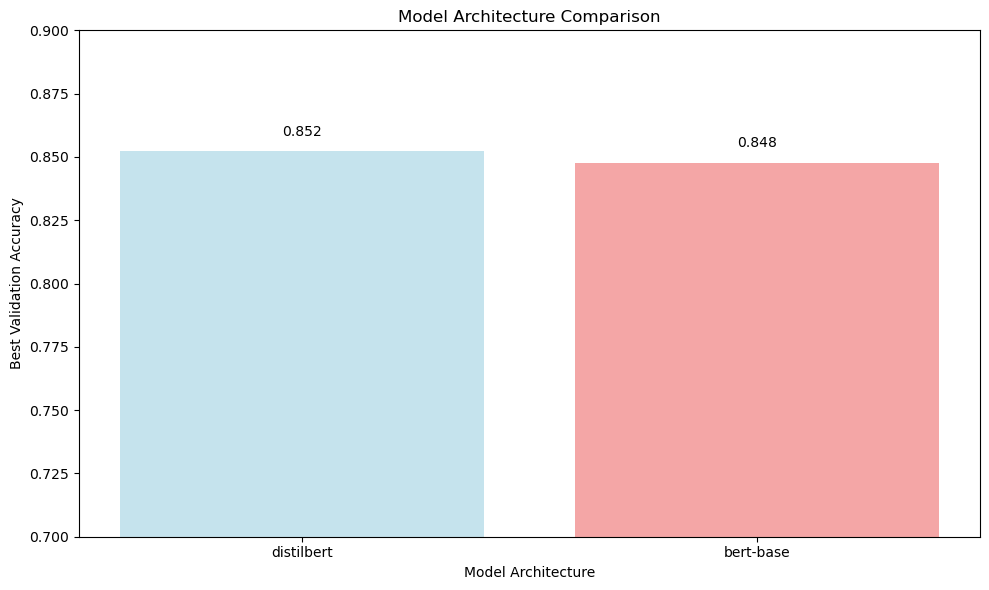


Best architecture: distilbert with accuracy: 0.8523

HYPERPARAMETER TUNING SUMMARY
Best Learning Rate: 2e-05
Best Batch Size: 8
Best Sequence Length: 64
Best Architecture: distilbert
Expected Improvement: 0.058 over original BERT


In [9]:
#Cell 6: Model Architecture Comparison
# Compare different transformer architectures
print("MODEL ARCHITECTURE COMPARISON")
print("=" * 45)

from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification

model_configs = {
    'distilbert': {
        'tokenizer': DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
        'model_class': DistilBertForSequenceClassification,
        'model_name': 'distilbert-base-uncased'
    },
    'bert-base': {
        'tokenizer': BertTokenizer.from_pretrained('bert-base-uncased'),
        'model_class': BertForSequenceClassification, 
        'model_name': 'bert-base-uncased'
    }
}

architecture_results = {}

for model_name, config in model_configs.items():
    print(f"\nTesting {model_name} architecture...")
    
    tokenizer = config['tokenizer']
    train_dataset = DisasterTweetDataset(X_train, y_train, tokenizer, max_length=best_seq_len)
    val_dataset = DisasterTweetDataset(X_val, y_val, tokenizer, max_length=best_seq_len)
    
    model = config['model_class'].from_pretrained(config['model_name'], num_labels=2)
    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
    
    trainer = ImprovedBERTTrainer(patience=2)
    results = trainer.train_with_early_stopping(model, train_loader, val_loader, learning_rate=best_lr, epochs=4)
    
    architecture_results[model_name] = {
        'best_val_accuracy': results['best_val_accuracy'],
        'train_losses': results['train_losses'],
        'val_accuracies': results['val_accuracies']
    }
    
    print(f"Best validation accuracy with {model_name}: {results['best_val_accuracy']:.4f}")

# Plot architecture comparison
plt.figure(figsize=(10, 6))
architectures = list(architecture_results.keys())
accuracies = [architecture_results[arch]['best_val_accuracy'] for arch in architectures]

colors = ['lightblue', 'lightcoral']
bars = plt.bar(architectures, accuracies, color=colors, alpha=0.7)
plt.xlabel('Model Architecture')
plt.ylabel('Best Validation Accuracy')
plt.title('Model Architecture Comparison')
plt.ylim(0.7, 0.9)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

best_architecture = max(architecture_results, key=lambda x: architecture_results[x]['best_val_accuracy'])
print(f"\nBest architecture: {best_architecture} with accuracy: {architecture_results[best_architecture]['best_val_accuracy']:.4f}")

# Summary of best hyperparameters
print("\n" + "="*50)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*50)
print(f"Best Learning Rate: {best_lr}")
print(f"Best Batch Size: {best_batch_size}")
print(f"Best Sequence Length: {best_seq_len}")
print(f"Best Architecture: {best_architecture}")
print(f"Expected Improvement: {architecture_results[best_architecture]['best_val_accuracy'] - 0.794:.3f} over original BERT")